In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [96]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
wl2, flux2, error2 = wl, flux, error # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)


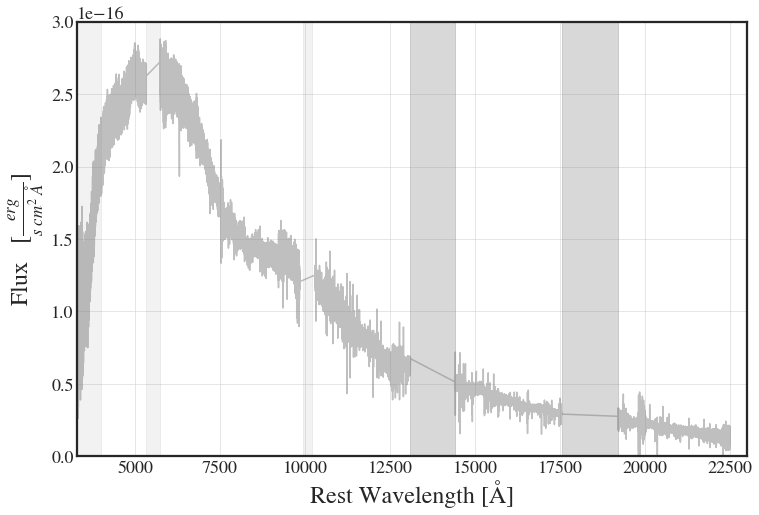

In [97]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [98]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod3(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual3(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod3(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]


def residual_p_cygni(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    intensity = temp(wav, T)
    v_out=vmax
    v_phot = vphot
    occul=occult2
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    intensity = N*intensity*(correction-1)
    
    if data is None:
        return intensity
    return (model - data)/error

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

In [99]:
def planck_with_mod1(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, tau   , lam, vref=vref, ve=ve , t0=t0)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    #pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3#*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2

def residual_p_cygni1(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    intensity = temp(wav, T)
    v_out=vmax
    v_phot = vphot
    occul=occult2
    lam = v['lam0']
   
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, tau   , lam, vref=vref, ve=ve , t0=t0)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    #pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3#*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    intensity = N*intensity*(correction-1)
    
    if data is None:
        return intensity
    return (model - data)/error

def residual1(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    
    lam = v['lam0']
    
    model = planck_with_mod1(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, lam = lam)
    
    if data is None:
        return model
    return (model - data)/error


In [100]:
def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)
        wl_out[h_index] = np.median(wl[ii:ii + binh], axis=0)

    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)

fit_res = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl", "./Data/OB5/OB5_3_peaks_XL.pkl"] 

for i in [0]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl, flux, error = x[:,0], x[:,1], x[:,2]
    exc_reg_2 = (x[:,0] > 4000) & (x[:,0] < 22500) & \
        (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) #& (~((x[:,0] > 9840) & (x[:,0] < 10300))) 
    wl3, flux3, error3,_ = bin_spectrum(wl, flux, error, ~exc_reg_2, 100)

pickle_in = open(fit_res[i],"rb")
emcee_res = pickle.load(pickle_in)
emcee_res.params['tau'].value=0
flux_fit_3 = residual3(emcee_res.params, wl3*1e-10)
flux_fit_bb = bb( wl2*1e-10, emcee_res.params['T'], emcee_res.params['N'])

Binning image by a factor: 100


<ipython-input-100-ed6d72c1d181>:110: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
<ipython-input-100-ed6d72c1d181>:110: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
<ipython-input-100-ed6d72c1d181>:112: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
<ipython-input-100-ed6d72c1d181>:112: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)


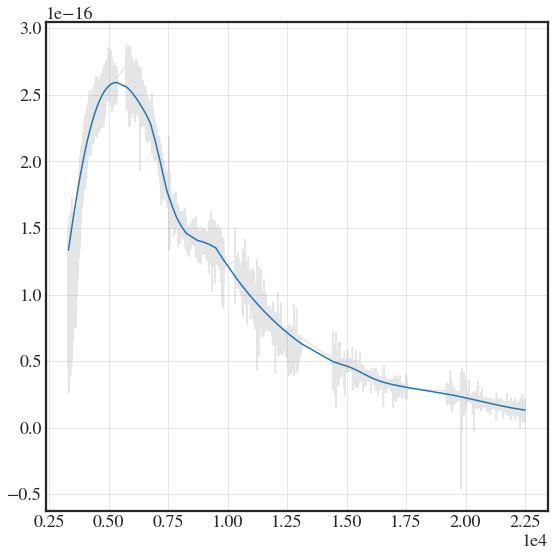

In [110]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
flux_fit = residual3(emcee_res3.params, wl2*1e-10)

reset_plt(18,24)
fig,ax = plt.subplots(figsize=(9,9))
#plt.plot(wl2, flux_fit)
#plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.05, s=1)
plt.plot(wl2, flux2, color='grey', alpha=0.2, label='X-shooter Spectra')
plt.plot(wl2, flux_fit)

In [116]:
np.mean( (flux2-flux_fit)**2/error2**2 )

2.267117096342701

In [114]:
np.mean( ((flux2-flux_fit)**2/error2**2)[(wl2>5000)] )

1.9509059280245444

In [107]:
from scipy import stats 

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
emcee_flatten = emcee_res3.flatchain

chi = residual3(emcee_res3.params, wl2[(wl2>6700) & (wl2<9500)]*1e-10, data=flux2[(wl2>6700) & (wl2<9500)], error = error2[(wl2>6700) & (wl2<9500)])
x = np.mean(chi**2)
chi = residual3(emcee_res3.params, wl2[(wl2>6700) & (wl2<9500)]*1e-10, data=flux2[(wl2>6700) & (wl2<9500)], error = error2[(wl2>6700) & (wl2<9500)]*np.sqrt(x))

emcee_res3.params['tau'].value=0
flux_fit = residual3(emcee_res3.params, wl2*1e-10)
flux_fit_bb = bb( wl2*1e-10, emcee_res3.params['T'], emcee_res3.params['N'])


In [108]:
chi = residual3(emcee_res3.params, wl2*1e-10, data=flux2, error = error2)
np.mean(chi**2)

12.311861694766575

In [74]:
np.mean(chi**2), 1 - stats.chi2.cdf(np.sum(chi**2), len(chi)-13)

(0.9990802320645252, 0.49841739904290205)

In [75]:
pickle_in = open("./data/OB1/OB1_1_line_50x5000.pkl","rb")
                 #OB1_1_line_50x3000_lamba0_set_by_4thepoch.pkl","rb")
emcee_res1 = pickle.load(pickle_in)

chi = residual1(emcee_res1.params, wl[(wl>6700) & (wl<9500)]*1e-10, 
                data=flux[(wl>6700) & (wl<9500)], 
                error = error[(wl>6700) & (wl<9500)]*np.sqrt(x))

np.mean(chi**2), 1 - stats.chi2.cdf(np.sum(chi**2), len(chi)-13)

(0.9872968275136844, 0.8391536343945047)

In [76]:
pickle_in = open("./data/OB1+OB2_1line_lam010643.pkl","rb")
                 #OB1_1_line_50x3000_lamba0_set_by_4thepoch.pkl","rb")
emcee_res1 = pickle.load(pickle_in)

chi = residual1(emcee_res1.params, wl[(wl>6700) & (wl<9500)]*1e-10, 
                data=flux[(wl>6700) & (wl<9500)], 
                error = error[(wl>6700) & (wl<9500)]*np.sqrt(x))

np.mean(chi**2), 1 - stats.chi2.cdf(np.sum(chi**2), len(chi)-13), stats.norm.ppf(stats.chi2.sf(np.sum(chi**2), len(chi)-14))

(1.0089849365013008, 0.20206911779449044, -0.8401942334952861)

In [29]:
emcee_res1.params

name,value,standard error,relative error,initial value,min,max,vary
T,5430.29530,1.96587327,(0.04%),5423.5299663701035,2500.00000,7500.00000,True
N,1.3405e-29,2.4764e-32,(0.18%),1.3506717604237555e-29,-inf,inf,True
vphot,0.28699014,7.9136e-04,(0.28%),0.29477398701640795,0.00000000,1.00000000,True
vmax,0.35431486,0.00127645,(0.36%),0.3739230806186863,0.00000000,1.00000000,True
t0,126000.000,,(0.36%),126000,-inf,inf,False
tau,1.51748535,0.10746281,(7.08%),1.6188804224758078,0.00000000,100.000000,True
vref,0.00000000,,(7.08%),0.0,0.00000000,1.00000000,False
ve,0.32821883,0.02417614,(7.37%),0.30139565057797957,0.00000000,1.00000000,True
occult,0.00108781,9.0622e-05,(8.33%),0.001159597903015852,0.00000000,2.00000000,True
amp1,0.27368040,0.00529977,(1.94%),0.2772439502870212,0.00000000,1.00000000,True


C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]
C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

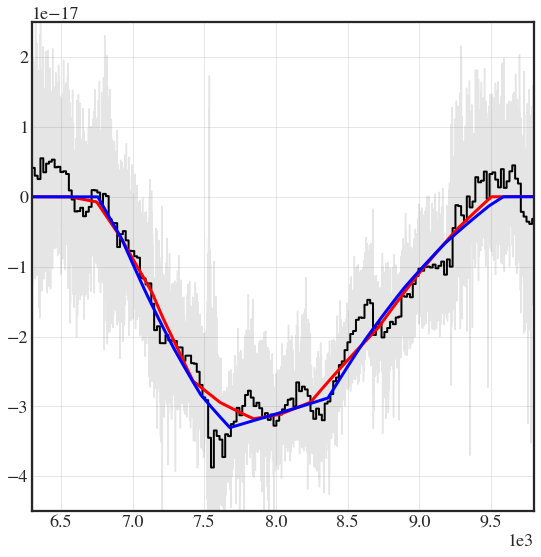

In [11]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb")
emcee_res3 = pickle.load(pickle_in)

reset_plt(18,24)
fig,ax = plt.subplots(figsize=(9,9))
#plt.plot(wl2, flux_fit)
#plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.05, s=1)
plt.plot(wl2, flux2-flux_fit, color='grey', alpha=0.2, label='X-shooter Spectra')
plt.step(wl3, flux3-flux_fit_3, alpha=1, color='k', where='mid', label='Binned X-Shooter Spectra', linewidth=2)
plt.xlim(6300,9800), plt.ylim(-4.5e-17,2.5e-17)

flux_fit2 = residual_p_cygni(emcee_res3.params, wl2*1e-10)
plt.plot(wl2, (flux_fit2), color='red', label='$v_{\parallel}=v_\perp$', linewidth=3)

flux_fit2 = residual_p_cygni1(emcee_res1.params, wl2*1e-10)
plt.plot(wl2, (flux_fit2), color='blue', label='$v_{\parallel}=v_\perp$', linewidth=3)


In [12]:
emcee_res3.params

name,value,standard error,relative error,initial value,min,max,vary
T,5440.89679,2.46160291,(0.05%),5435.716791746477,2500.00000,7500.00000,True
N,1.3338e-29,3.1434e-32,(0.24%),1.3404076532489784e-29,-inf,inf,True
vphot,0.27793591,6.1103e-04,(0.22%),0.27768223610679355,0.00000000,1.00000000,True
vmax,0.34358755,7.0672e-04,(0.21%),0.34633402047380324,0.00000000,1.00000000,True
t0,126000.000,,(0.21%),126000,-inf,inf,False
tau,19.8889462,4.75750986,(23.92%),35.43711858345176,0.00000000,100.000000,True
vref,0.00000000,,(23.92%),0.0,0.00000000,1.00000000,False
ve,0.08640330,0.00663807,(7.68%),0.07449505547902187,0.00000000,1.00000000,True
occult,0.01110866,0.03904019,(351.44%),0.0005456328535526188,0.00000000,2.00000000,True
amp1,0.29438175,0.00724750,(2.46%),0.26169986240919846,0.00000000,5.00000000,True


In [13]:
20*np.exp(-0.3/0.08)

0.4703549171201821

In [14]:
np.mean(chi**2), len(chi)

(0.9872968275136844, 14134)

In [15]:
from scipy import stats

1 - stats.chi2.cdf(np.sum(chi**2), len(chi)-14)

0.8376935929881856

In [11]:
stats.chi2.sf(np.sum(chi**2), len(chi)-14)

1.2092336412044323e-05

In [12]:
stats.norm.ppf(stats.chi2.sf(np.sum(chi**2), len(chi)-14))

-4.222276910414356

In [126]:
stats.norm.ppf(0.0015)

-2.9677379253417833

In [81]:
np.sum(chi**2), len(chi)

(16158.296203017158, 14134)

In [57]:
0.00047/0.00957

0.04911180773249738

In [ ]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(9,9))
#plt.plot(wl2, flux_fit)
#plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.05, s=1)
plt.plot(wl2, flux2-flux_fit, color='grey', alpha=0.2, label='X-shooter Spectra')
plt.step(wl3, flux3-flux_fit_3, alpha=1, color='k', where='mid', label='Binned X-Shooter Spectra', linewidth=3)



C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]


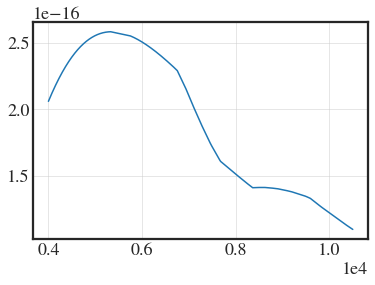

In [49]:
plt.plot( wl[(wl>4000) & (wl<10500)], residual1(emcee_res1.params, wl[(wl>4000) & (wl<10500)]*1e-10) )
plt.plot( wl[(wl>4000) & (wl<10500)], residual1(emcee_res3.params, wl[(wl>4000) & (wl<10500)]*1e-10) )

In [117]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl2, flux2, error2 = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

In [118]:
pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb")
emcee_res3 = pickle.load(pickle_in)
emcee_flatten = emcee_res.flatchain

chi = residual3(emcee_res3.params, wl2*1e-10, data=flux2, 
                error = error2)#*np.sqrt(1.68756))

x = np.mean(chi**2)
print('increase =',x)

chi = residual3(emcee_res3.params, wl2[(wl2>7000) & (wl2<12000)]*1e-10, data=flux2[(wl2>7000) & (wl2<12000)], 
                error = error2[(wl2>7000) & (wl2<12000)])#*np.sqrt(1.68756))

x = np.mean(chi**2)
x

increase = 1.675420885489351


C:\Users\asnep\Downloads\Kilonova\pcygni_5.py:546: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, *self.args), epsabs=1)[0]


1.634923257882459

In [119]:
pickle_in = open("./data/OB2/OB2_2_line_50x3000.pkl","rb")
emcee_res1 = pickle.load(pickle_in)
emcee_flatten = emcee_res1.flatchain

chi = residual1(emcee_res1.params, wl2[(wl2>7000) & (wl2<12000)]*1e-10, data=flux2[(wl2>7000) & (wl2<12000)], 
                error = error2[(wl2>7000) & (wl2<12000)])#*np.sqrt(x))
np.mean(chi**2)

1.694956338395902

In [58]:
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    intensity = temp(wav, T)
    
    # One Line Pcygni
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, tau   , lam, vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2

def residual2(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T2"], v["N2"], v["vphot2"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax2"], v["tau2"], v["vref"], v["ve2"], v["occult_2"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1_2"], v["amp2_2"], v["cen1"], v["cen2"], v["sig1_2"], v["sig2_2"]
    
    lam = v['lam0']
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, lam = lam)
    
    if data is None:
        return model
    return (model - data)/error

pickle_in = open("./Data/OB1+OB2_1line_lam010643.pkl","rb")
emcee_res1 = pickle.load(pickle_in)
emcee_flatten = emcee_res1.flatchain

chi = residual2(emcee_res1.params, wl2[(wl2>7000) & (wl2<12000)]*1e-10, data=flux2[(wl2>7000) & (wl2<12000)], 
                error = error2[(wl2>7000) & (wl2<12000)]*np.sqrt(x))
np.mean(chi**2)

1.048688987721561

In [59]:
stats.chi2.sf(np.sum(chi**2), len(chi)-14), len(chi)

(3.0620462875359063e-06, 17197)

In [60]:
stats.norm.ppf(stats.chi2.sf(np.sum(chi**2), len(chi)-14))

-4.522059198076425

In [60]:
stats.chi2.sf(np.sum(chi**2), len(chi)-14), len(chi)

(0.0002879387124464817, 17197)

In [61]:
stats.norm.ppf(7.221577648739943e-05), stats.norm.ppf(0.000287)

(-3.8004534434765995, -3.4436114325458087)

In [144]:
np.std(emcee_flatten['lam0']), np.mean(emcee_flatten['lam0'])

(29.00488429742673, 10455.464700691768)

In [137]:
emcee_res1.params

name,value,standard error,relative error,initial value,min,max,vary
T,3952.22994,5.61727500,(0.14%),3885.6246410631175,2500.00000,7500.00000,True
N,2.6789e-29,2.4240e-31,(0.90%),2.9283508300679505e-29,-inf,inf,True
vphot,0.25563362,0.00124503,(0.49%),0.23987609358610124,0.00000000,1.00000000,True
vmax,0.28847466,0.00132381,(0.46%),0.2742280954961268,0.00000000,1.00000000,True
t0,212400.000,,(0.46%),212400,-inf,inf,False
tau,1.62592008,0.55485052,(34.13%),1.5981110581192914,0.00000000,20.0000000,True
vref,0.00000000,,(34.13%),0.0,0.00000000,1.00000000,False
ve,3.82593927,2.21515571,(57.90%),6.60018362959907,0.00000000,10.0000000,True
occult,1.97705386,0.09689492,(4.90%),1.867186552418812,0.10000000,10.0000000,True
amp1,0.77856414,0.06473883,(8.32%),0.64712368727546,0.01000000,5.00000000,True


0.2937003372276614
Lum_dist =  46.11043258199298 + 0.37910861936448725 - 0.36935824973601683
<Parameter 've', value=0.24527416509372563 +/- 0.0475, bounds=[0:1]>
1.349507007703831e-29
0.2564141755137846
Lum_dist =  45.84588726768555 + 0.4344385078741908 - 0.4485670657476888
<Parameter 've', value=3.751539439670099 +/- 0.108, bounds=[0:10]>
2.677356844644281e-29
0.28699014216855584
Lum_dist =  44.808170220370855 + 0.415096464156683 - 0.4035724470797888
<Parameter 've', value=0.32821883044298644 +/- 0.0242, bounds=[0:1]>
1.3405210711639038e-29


(45.60988431764227, 0.2341550576873955)

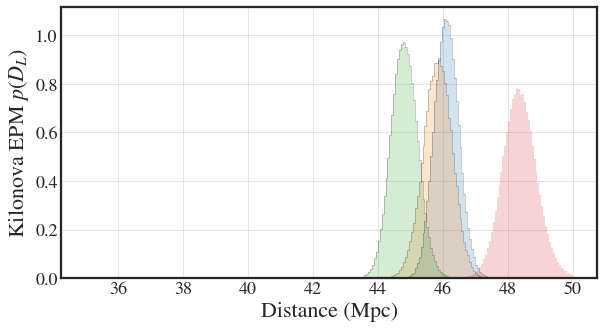

In [36]:
n_days = [1.43, 2.42, 1.43]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_1_line_50x5000.pkl", "./data/OB2/OB2_2_line_50x3000.pkl", "./Data/OB1+OB2_1line_lam010643.pkl"] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9.6,5))
    
steady = [22*2000, 25*2000, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
#multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:3]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=250, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h = plt.hist(dl, bins=250, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

vphot = np.array(emcee_flatten['vphot2'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
dl = lum_dist_arr(np.array(emcee_flatten['N2'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=2.42)[steady[idx]:]
    
h = plt.hist(dl, bins=250, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
#plt.xlim(41.6, 44.6)

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)

mu, sigma

In [34]:
1.8/43/2

0.020930232558139535

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))#, nrows=5, sharex=True)

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.008, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(37,51), color=color_list[idx])
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.35,
                 density=True, label='Epoch '+str(idx+1)+'; Full Model', range=(37,51), color=color_list[idx])    
    
    ax[idx].plot(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
         , color='grey', alpha=1 )
    ax[idx].fill_between(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
                 color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    print(np.mean(emcee_res.flatchain['vphot']), np.std(emcee_res.flatchain['vphot']))


    
files = ["./Data/OB1/OB1_3_peaks_lambda_13000.pkl", "./Data/OB2/OB2_3_peaks_lambda_13000.pkl", 
         "./Data/OB3/OB3_3_peaks_lambda_13000_3.pkl", "./Data/OB4/OB4_3_peaks_lambda_13000_1.pkl",
         "./Data/OB5/OB5_3_peaks_lambda_13000_1.pkl" ] 


steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
color_list = ['blue', 'orange', 'green', 'red', 'purple']
x=0